# Simulación de situación base y de posibles soluciones

In [234]:
import json
import pandas as pd
import random
import heapq
from collections import deque, defaultdict
from datetime import datetime
import uuid
from pathlib import Path

class Node:
    def __init__(self, name, mu, servers):
        self.name = name
        self.mu = mu # tasa de servicio de cada servidor
        self.servers = servers # número de servidores
        self.busy = 0 # servidores ocupados
        self.queue = deque() # cola de clientes (pid, tiempo_de_llegada_a_cola)
        # estadísticas
        self.area_q = 0.0 # integral de longitud de cola
        self.area_busy = 0.0 # integral de servidores ocupados
        self.last_event_time = 0.0
        self.num_served = 0 # número de clientes servidos

class Event:
    def __init__(self, time, kind, node_name, pid, external=False):
        self.time = time # instante del evento
        self.kind = kind # 'arrival' o 'departure'
        self.node_name = node_name # nodo donde ocurre
        self.pid = pid # identificador del cliente
        self.external = external # si es llegada externa
    def __lt__(self, other):
        return self.time < other.time

## Función para simular situación base (antes de propuestas de soluciones a problemas)

En un hospital se ha organizado un proceso de atención a pacientes que transitan por diversas etapas. Al llegar al hospital, los pacientes ingresan a una de dos salas de registro, donde esperan su turno para procesar su admisión. Una vez completado el registro, los pacientes pasan a las salas de examinación; cada sala de registro deriva a su correspondiente sala de examinación. En estas salas se evalúa el estado de cada paciente para determinar los siguientes pasos en el proceso de atención médica.

Luego, los pacientes se dirigen a la sala de consulta asociada a la sala de examinación de la que proviene. La consulta incluye también el suministro de medicamentos e indicaciones necesarias para el alta médica. Una vez finalizada la consulta, el paciente finalizó su proceso en el hospital.

Los administradores del hospital buscan principalmente reducir los tiempos de espera de los pacientes.

**Información extra**

Aunque los pacientes llegan de forma aleatoria al hospital, la cantidad de pacientes que llega por hora a cada sala de registro se ha mantenido estable en dos cantidades respectivas de pacientes por hora fija. Esta cantidad puede saberse ya que el hospital registra la fecha y hora en la que cada paciente llega al hospital a esperar su turno para empezar su registro, y también almacena cuándo sale y entra de cada sala; de esta forma también puede saberse cuántos pacientes por hora entran y salen de cada etapa.

**(!) Ignorar. Es para la solución 2 pero este problema no se centraría en mejorar tiempos de espera:** *En total, el hospital cuenta con 5 médicos de cabecera que pueden repartirse entre las dos salas de consulta. Los administradores del hospital han determinado que cada sala de consulta debe mantenerse ocupada durante menos del 80% del tiempo para evitar que los médicos lleguen a un punto de desgaste excesivo. Actualmente, cada médico es capaz de atender a 2 pacientes por hora en la sala en la sala de consulta 1 y 2.2 pacientes por hora en la sala de consulta 2. Sin embargo, si es necesario, los médicos asignados a la sala de consulta 1 pueden atender a 2.2 pacientes por hora y 2.6 pacientes por hora en la sala de consulta 2, con la condición de que la ocupación de la sala de consulta se mantenga en 72% o menos.*

In [235]:
def simulate_base(T: float, lambda1: float, lambda2: float, nodes: dict[str, Node]
        ) -> dict[str, dict[str, float]]:
    """
    Simulación base (original) de la situación planteada inicialmente.
    
    Args:
        T: Tiempo de simulación (horas).
        lambda1: Tasa de llegada externa a 'reg1' (pacientes/hora).
        lambda2: Tasa de llegada externa a 'reg2' (pacientes/hora).
        nodes: Diccionario <nombre, Node>
    
    Returns:
        metrics: Diccionario <nombre_nodo, dict<nombre_metrica, float>>
            Explicación de las métricas:
            - Wq: Tiempo promedio en cola (horas).
            - W: Tiempo promedio en el sistema (horas).
            - Lq: Longitud promedio de la cola (número de clientes en cola).
            - L: Longitud promedio del sistema (número de clientes en el sistema).
            - rho: Proporción de tiempo ocupado por los servidores.
            - throughput: Rendimiento (número de clientes atendidos por hora).
    """
    future = []
    t = 0.0
    pid_ctr = 0
    waits = defaultdict(list)

    # primeras llegadas externas a reg1 y reg2
    heapq.heappush(future, Event(random.expovariate(lambda1), 'arrival', 'reg1', pid_ctr, True))
    pid_ctr += 1
    heapq.heappush(future, Event(random.expovariate(lambda2), 'arrival', 'reg2', pid_ctr, True))
    pid_ctr += 1

    while future:
        ev = heapq.heappop(future)
        if ev.time > T:
            break
        # avanzar reloj y actualizar áreas
        dt_global = ev.time - t
        t = ev.time
        for nd in nodes.values():
            nd.area_q += len(nd.queue)*dt_global
            nd.area_busy += nd.busy*dt_global
            nd.last_event_time = t

        node = nodes[ev.node_name]
        if ev.kind == 'arrival':
            # reprogramar siguiente llegada externa
            if ev.external:
                lam = lambda1 if ev.node_name=='reg1' else lambda2
                heapq.heappush(future, Event(t+random.expovariate(lam),
                                             'arrival', ev.node_name, pid_ctr, True))
                pid_ctr += 1
            # si hay servidor libre
            if node.busy < node.servers:
                node.busy += 1
                waits[node.name].append(0.0)
                dt = random.expovariate(node.mu)
                heapq.heappush(future, Event(t+dt, 'departure', node.name, ev.pid))
            else:
                node.queue.append((ev.pid, t))

        else:  # departure
            node.num_served += 1
            node.busy -= 1
            # si hay cola, atiende siguiente
            if node.queue:
                pid_q, t_arr = node.queue.popleft()
                waits[node.name].append(t - t_arr)
                node.busy += 1
                dt = random.expovariate(node.mu)
                heapq.heappush(future, Event(t+dt, 'departure', node.name, pid_q))
            # ruta al siguiente nodo
            if ev.node_name == 'reg1':
                nxt = 'exam1'
            elif ev.node_name == 'reg2':
                nxt = 'exam2'
            elif ev.node_name == 'exam1':
                nxt = 'consult1'
            elif ev.node_name == 'exam2':
                nxt = 'consult2'
            elif ev.node_name.startswith('consult'):
                continue # en consulta sale del sistema
            else:
                raise ValueError(f"Evento de salida inesperado: {ev.node_name}")
            # llegada inmediata
            heapq.heappush(future, Event(t, 'arrival', nxt, ev.pid, False))

    # calcular métricas
    metrics = {}
    for name, nd in nodes.items():
        Lq = nd.area_q / T
        L = nd.area_q / T + nd.area_busy / T
        rho = nd.area_busy / T / nd.servers
        Wq = sum(waits[name]) / len(waits[name]) if waits[name] else 0.0
        W = L / (nd.num_served / T) if nd.num_served > 0 else 0.0
        X   = nd.num_served / T
        metrics[name] = {
            'Wq': Wq,
            'W': W,
            'Lq': Lq,
            'L': L,
            'rho': rho,
            'throughput': X
        }
    return metrics

## Función para simular situación de la solución 1 (ignorar)

**(!) No se puede usar esto porque se dejaría una única entrada al sistema (tenemos que trabajar múltiples entradas). Ignorar esta solución.**

Actualmente, se tienen dos salas de registro separadas como estaciones de servicio independientes con colas separadas e independientes. 

Esta solución 1 consiste en modificar el sistema de colas de la siguiente manera: **Una sola sala de registro con 2 servidores y una única cola**. La sala de registro sería un modelo M/M/2 con tasa de llegada lambda = lambda1 + lambda2.

Si son dos M/M/1 independientes, cada cola se comporta aisladamente.

Si es un M/M/2 con cola compartida, se consigue, para la misma capacidad total, menores tiempos de espera promedio (la famosa ganancia del pooling).

"It is generally accepted that operating with a combined (i.e., pooled) queue rather than separate (i.e., dedicated) queues is beneficial mainly because pooling queues reduces long-run average throughput time" (Sunar, N., 2018, recuperado de: https://kenaninstitute.unc.edu/publication/pooled-or-dedicated-queues-when-customers-are-delay-sensitive/).


In [236]:
import copy

def simulate_pooled(T: float, lambda1: float, lambda2: float, nodes: dict[str, Node]
        ) -> dict[str, dict[str, float]]:
    """
    Versión mejorada: un único nodo 'reg' con 2 servidores y cola compartida.
    Las llegadas externas a 'reg' ocurren a tasa (lambda1+lambda2).
    Al terminar el registro, se asigna a exam1/exam2 con prob. proporcional
    a lambda1/(lambda1+lambda2) y lambda2/(lambda1+lambda2).
    """
    future = []
    t = 0.0
    pid_ctr = 0
    waits = defaultdict(list)
    lam_tot = lambda1 + lambda2

    # primera llegada externa a 'reg'
    heapq.heappush(future, Event(random.expovariate(lam_tot), 'arrival', 'reg', pid_ctr, True))
    pid_ctr += 1

    while future:
        ev = heapq.heappop(future)
        if ev.time > T:
            break
        # avanzar reloj y actualizar áreas
        dt_global = ev.time - t
        t = ev.time
        for nd in nodes.values():
            nd.area_q += len(nd.queue)*dt_global
            nd.area_busy += nd.busy*dt_global
            nd.last_event_time = t

        node = nodes[ev.node_name]
        if ev.kind == 'arrival':
            # reprogramar siguiente llegada externa (solo en 'reg')
            if ev.external:
                heapq.heappush(future, Event(t+random.expovariate(lam_tot),
                                             'arrival', 'reg', pid_ctr, True))
                pid_ctr += 1
            # si hay servidor libre
            if node.busy < node.servers:
                node.busy += 1
                waits[node.name].append(0.0)
                dt = random.expovariate(node.mu)
                heapq.heappush(future, Event(t+dt, 'departure', node.name, ev.pid))
            else:
                node.queue.append((ev.pid, t))

        else:  # departure
            node.num_served += 1
            node.busy -= 1
            # si hay cola, atiende siguiente
            if node.queue:
                pid_q, t_arr = node.queue.popleft()
                waits[node.name].append(t - t_arr)
                node.busy += 1
                dt = random.expovariate(node.mu)
                heapq.heappush(future, Event(t+dt, 'departure', node.name, pid_q))
            # ruta al siguiente nodo
            if ev.node_name == 'reg':
                # asignar proporcionalmente
                p1 = lambda1 / lam_tot
                nxt = 'exam1' if random.random() < p1 else 'exam2'
            elif ev.node_name.startswith('exam'):
                nxt = 'consult1' if random.random()<0.5 else 'consult2'
            elif ev.node_name.startswith('consult'):
                continue
            else:
                raise ValueError(f"Evento de salida inesperado: {ev.node_name}")
            # llegada inmediata
            heapq.heappush(future, Event(t, 'arrival', nxt, ev.pid, False))

    # calcular métricas
    metrics = {}
    for name, nd in nodes.items():
        Lq = nd.area_q / T
        rho = nd.area_busy / T / nd.servers
        Wq = sum(waits[name]) / len(waits[name]) if waits[name] else 0.0
        X   = nd.num_served / T
        metrics[name] = {
            'Wq': Wq,
            'Lq': Lq,
            'rho': rho,
            'throughput': X
        }
    return metrics



## Simular situación de la solución 2 (ignorar)

**(!) Esta solución no busca mejorar tiempos de atención al cliente, sino más bien mantenerse en una utilización máxima. No creo que deberíamos usar esto.**

Se busca mantener la utilización de cada sala de consulta en menos del 80%. Sin embargo, la sala de consulta 1 tiene una utilización del 87% y la sala de consulta 2 cercana al 80%.

Esta solución consiste en modificar el sistema de colas de la siguiente manera: se pide a los médicos de la sala de consulta 2 aumentar su eficiencia a cambio de reducir la utilización máxima al 72% en esa sala; a la sala de consulta 1 se le asigna un médico adicional.



## Simular situación de la solución 3

En la situación base, la sala de examinación 1 siempre dirige a la sala de consulta 1 y la sala de examinación 2 siempre dirige a la sala de consulta 2. 

En lugar de hacer estas direcciones, se utiliza un enfoque parecido al JSQ (join the shortest queue), pero para simplificar el modelo no se utiliza el JSQ como tal (que implica dirigir dinámicamente la salida a la estación de servicio con cola más corta en el momento), sino sólo su principio de enviar mayor proporción de las salidas de las salas de consulta a la sala de consulta con media de clientes en cola menor (L_q).

Para esto, se crea una nueva simulación con los siguientes pasos:


1. Correr la simulación base y extraer $L_{q_{c1}}$ (consulta 1) y $L_{q_{c2}}$ (consulta 2).
2. Definir probabilidades de enrutamiento fijas $p_{c1}$ = $\frac{L_{q_{c2}}}{L_{q_{c1}}+L_{q_{c2}}}, p_{c2}$ = $\frac{L_{q_{c1}}}{L_{q_{c1}}+L_{q_{c2}}}$ (envías más flujo al nodo que tenía menor cola promedio en la simulación base; hay una probabilidad de $p_{c1}$ de enviar el paciente de la sala de examinación—tanto para la sala 1 como para la sala 2—a la sala de consulta 1).
3. Simular de nuevo con esas probabilidades estáticas ya asignadas.
4. Comparar métricas de desempeño $W$, $L$, $W_q$, $L_q$ y $\rho$ (rho) antes y después.

$p_{c1}$ termina dando 0.1, lo que da un 90% de flujo hacia el consultorio 2. Esto desborda la cantidad de clientes que entran a la estación de servicio comparado con la cantidad que puede atender por hora, por lo que nunca alcanza un estado estable. Por esto, esta solución no es óptima pero se utiliza en la solución 4 el mismo proceso pero utilizando mu (tasa de servicio) para calcular la probabilidad de enrutamiento.

In [237]:
def simulate_solution3(T: float, lambda1: float, lambda2: float, nodes: dict[str, Node],
        p_to_consult1: float) -> dict[str, dict[str, float]]:
    """
    Simulación de la solución 3: Enviar mayor proporción de pacientes salientes
    de las salas de consultas a la sala de consulta con media de clientes en cola menor.
    
    Args:
        T: Tiempo de simulación (horas).
        lambda1: Tasa de llegada externa a 'reg1' (pacientes/hora).
        lambda2: Tasa de llegada externa a 'reg2' (pacientes/hora).
        nodes: Diccionario <nombre, Node>
    
    Returns:
        metrics: Diccionario <nombre_nodo, dict<nombre_metrica, float>>
            Explicación de las métricas:
            - Wq: Tiempo promedio en cola (horas).
            - W: Tiempo promedio en el sistema (horas).
            - Lq: Longitud promedio de la cola (número de clientes en cola).
            - L: Longitud promedio del sistema (número de clientes en el sistema).
            - rho: Proporción de tiempo ocupado por los servidores.
            - throughput: Rendimiento (número de clientes atendidos por hora).
    """
    future = []
    t = 0.0
    pid_ctr = 0
    waits = defaultdict(list)

    # primeras llegadas externas a reg1 y reg2
    heapq.heappush(future, Event(random.expovariate(lambda1), 'arrival', 'reg1', pid_ctr, True))
    pid_ctr += 1
    heapq.heappush(future, Event(random.expovariate(lambda2), 'arrival', 'reg2', pid_ctr, True))
    pid_ctr += 1

    while future:
        ev = heapq.heappop(future)
        if ev.time > T:
            break
        # avanzar reloj y actualizar áreas
        dt_global = ev.time - t
        t = ev.time
        for nd in nodes.values():
            nd.area_q += len(nd.queue)*dt_global
            nd.area_busy += nd.busy*dt_global
            nd.last_event_time = t

        node = nodes[ev.node_name]
        if ev.kind == 'arrival':
            # reprogramar siguiente llegada externa
            if ev.external:
                lam = lambda1 if ev.node_name=='reg1' else lambda2
                heapq.heappush(future, Event(t+random.expovariate(lam),
                                             'arrival', ev.node_name, pid_ctr, True))
                pid_ctr += 1
            # si hay servidor libre
            if node.busy < node.servers:
                node.busy += 1
                waits[node.name].append(0.0)
                dt = random.expovariate(node.mu)
                heapq.heappush(future, Event(t+dt, 'departure', node.name, ev.pid))
            else:
                node.queue.append((ev.pid, t))

        else:  # departure
            node.num_served += 1
            node.busy -= 1
            # si hay cola, atiende siguiente
            if node.queue:
                pid_q, t_arr = node.queue.popleft()
                waits[node.name].append(t - t_arr)
                node.busy += 1
                dt = random.expovariate(node.mu)
                heapq.heappush(future, Event(t+dt, 'departure', node.name, pid_q))
            # ruta al siguiente nodo
            if ev.node_name == 'reg1':
                nxt = 'exam1'
            elif ev.node_name == 'reg2':
                nxt = 'exam2'
            elif ev.node_name.startswith('exam'):
                # (*Cambio de esta solución*)
                # Routing estático
                nxt = 'consult1' if random.random() < p_to_consult1 else 'consult2'
            elif ev.node_name.startswith('consult'):
                continue # en consulta sale del sistema
            else:
                raise ValueError(f"Evento de salida inesperado: {ev.node_name}")
            # llegada inmediata
            heapq.heappush(future, Event(t, 'arrival', nxt, ev.pid, False))

    # calcular métricas
    metrics = {}
    for name, nd in nodes.items():
        Lq = nd.area_q / T
        L = nd.area_q / T + nd.area_busy / T
        rho = nd.area_busy / T / nd.servers
        Wq = sum(waits[name]) / len(waits[name]) if waits[name] else 0.0
        W = L / (nd.num_served / T) if nd.num_served > 0 else 0.0
        X   = nd.num_served / T
        metrics[name] = {
            'Wq': Wq,
            'W': W,
            'Lq': Lq,
            'L': L,
            'rho': rho,
            'throughput': X
        }
    return metrics

## Simular situación de la solución 4

Se sigue el mismo proceso que en la solución 3, sólo que se cambia:

2. Definir probabilidades de enrutamiento fijas $p_{c1}$ = $\frac{\mu_{c1}}{\mu_{c1}+\mu_{c2}}, p_{c2}$ = $\frac{\mu_{c1}}{\mu_{c1}+\mu_{c2}}$ (envías más flujo al nodo que tenía mayor tasa de servicio en la simulación base—cabe recordar que las tasas de servicio son las mismas en la simulación base y en la simulación de la solución 3 y 4).

Utiliza la misma función de simulación que la solución 3, pues sólo cambia el valor asignado al parámetro `p_to_consult1`.

Al asignar estas probabilidades de enrutamiento, curiosamente $\rho$ toma el mismo valor en el consultorio 1 y en el consultorio 2. Esto es un indicador de que ambas estaciones de servicio tienen la misma fracción esperada de tiempo que los servidores individuales están ocupados.

## Ejecutar simulaciones

In [238]:

def save_simulation(simulation_name: str, run_dir: Path, metrics: dict[str, dict[str, float]], nodes: dict[str, Node],
                    lambda1: float, lambda2: float, T: float, seed: int) -> None:
    # Guardar los resultados de la simulación en runs/{timestamp} {unique_id}/{simulation_name}
    path = run_dir / simulation_name
    path.mkdir(parents=True, exist_ok=True)

    metrics_df = pd.DataFrame(metrics).T
    metrics_df = metrics_df[['Wq', 'Lq', 'rho', 'throughput']].round(3)
    results_path = path / 'simulation_results.csv'
    metrics_df.to_csv(results_path)
    print(f"Resultados de la simulación {simulation_name} guardados en '{results_path}'.")

    params = {
        'seed': seed,
        'nodes': {name: {'mu': node.mu, 'servers': node.servers} for name, node in nodes.items()},
        'lambda1': lambda1,
        'lambda2': lambda2,
        'T': T,
    }
    params_path = path / 'simulation_params.json'
    with params_path.open('w') as f:
        json.dump(params, f, indent=4)
    print(f"Parámetros de la simulación {simulation_name} guardados en '{params_path}'.")

def display_simulation_metrics(simulation_name: str, metrics: dict[str, dict[str, float]]):
    # Convertir los resultados de la simulación en un DataFrame y mostrarlo como una tabla
    df = pd.DataFrame(metrics).T
    # show always 4 decimales even if it's 0.0000
    df = df.style.format(na_rep='0.0000')
    print("Resultados de la simulación:", simulation_name)
    display(df)

### Entradas (*modificable por el usuario*)

In [239]:
# Para obtener exactamente los mismos resultados de una run en específico, 
# sólo usa la misma semilla, mismos parámetros y mismos nodos.

# Horas de simulación
T = 100000.0/4
seed = random.randint(1, 100000) # semilla aleatoria
random.seed(seed)
print(f"Semilla aleatoria: {seed}")

# Parámetros de llegada externa (pacientes/hora)
lambda1 = 4.0 # a reg1
lambda2 = 3.0 # a reg2

# Modelo base: dos salas
nodes_base = {
    'reg1':    Node('reg1',     mu=10.0, servers=1),
    'reg2':    Node('reg2',     mu=10.0, servers=1),
    'exam1':   Node('exam1',    mu=6.0,  servers=1),
    'exam2':   Node('exam2',    mu=6.0,  servers=1),
    'consult1':Node('consult1', mu=2.5,  servers=2),
    'consult2':Node('consult2', mu=3.0,  servers=2),
}

# Modelo solución 3
nodes_solution3 = {
    'reg1':    Node('reg1',     mu=10.0, servers=1),
    'reg2':    Node('reg2',     mu=10.0, servers=1),
    'exam1':   Node('exam1',    mu=6.0,  servers=1),
    'exam2':   Node('exam2',    mu=6.0,  servers=1),
    'consult1':Node('consult1', mu=2.5,  servers=2),
    'consult2':Node('consult2', mu=3.0,  servers=2),
}

# Modelo solución 4
nodes_solution4 = copy.deepcopy(nodes_solution3)

Semilla aleatoria: 36008


### Correr simulaciones

In [240]:
# Uncomment to generate a random seed each time this cell is run
seed = random.randint(1, 100000) # semilla aleatoria
random.seed(seed)
print(f"Semilla aleatoria: {seed}")

# Crear un directorio único dentro de "runs"
timestamp = datetime.now().strftime("%d-%m-%Y %H_%M_%S")
unique_id = uuid.uuid4().hex[:6] # ID único

# Crear la carpeta común usando timestamp y unique_id
run_dir = Path("runs") / f"{timestamp} {unique_id}"
run_dir.mkdir(parents=True, exist_ok=True)

print("------ Simulación base ------")
base_metrics = simulate_base(T, lambda1, lambda2, copy.deepcopy(nodes_base))
display_simulation_metrics("Base", base_metrics)
save_simulation("base", run_dir, base_metrics, nodes_base, lambda1, lambda2, T, seed)

print("------ Simulación de la solución 3 ------")
# Utilizar Lq de la simulación base para calcular la proporción de pacientes que van a consult1
L_q1 = base_metrics['consult1']['Lq']
L_q2 = base_metrics['consult2']['Lq']
p_to_consult1 = L_q2 / (L_q1 + L_q2)
print(f"Proporción de pacientes que van a consult1: {p_to_consult1:.4f}")
solution3_metrics = simulate_solution3(T, lambda1, lambda2, copy.deepcopy(nodes_solution3), p_to_consult1)
display_simulation_metrics("Solución 3", solution3_metrics)
save_simulation("solution3", run_dir, solution3_metrics, nodes_solution3, lambda1, lambda2, T, seed)

print("------ Simulación de la solución 4 ------")
# Utilizar mu de la simulación base para calcular la proporción de pacientes que van a consult1
mu1 = nodes_base['consult1'].mu
mu2 = nodes_base['consult2'].mu
p_to_consult1 = mu1 / (mu1 + mu2)
print(f"Proporción de pacientes que van a consult1: {p_to_consult1:.4f}")
solution4_metrics = simulate_solution3(T, lambda1, lambda2, copy.deepcopy(nodes_solution4), p_to_consult1)
display_simulation_metrics("Solución 3", solution4_metrics)
save_simulation("solution3", run_dir, solution4_metrics, nodes_solution4, lambda1, lambda2, T, seed)



Semilla aleatoria: 98838
------ Simulación base ------
Resultados de la simulación: Base


,Wq,W,Lq,L,rho,throughput
reg1,0.069479,0.170205,0.277076,0.678766,0.401690,3.987920
reg2,0.043324,0.143205,0.129466,0.427936,0.298471,2.988280
exam1,0.326079,0.492333,1.300379,1.963305,0.662926,3.987760
exam2,0.168720,0.336675,0.504182,1.006067,0.501885,2.988240
consult1,0.716547,1.118540,2.857382,4.460289,0.801453,3.987600
consult2,0.112387,0.448539,0.335840,1.340307,0.502234,2.988160


Resultados de la simulación base guardados en 'runs\10-05-2025 04_31_09 32700c\base\simulation_results.csv'.
Parámetros de la simulación base guardados en 'runs\10-05-2025 04_31_09 32700c\base\simulation_params.json'.
------ Simulación de la solución 3 ------
Proporción de pacientes que van a consult1: 0.1052
Resultados de la simulación: Solución 3


,Wq,W,Lq,L,rho,throughput
reg1,0.067151,0.166992,0.269124,0.669259,0.400135,4.007720
reg2,0.043532,0.143491,0.130019,0.428573,0.298553,2.986760
exam1,0.328850,0.495138,1.317937,1.984374,0.666437,4.007720
exam2,0.167146,0.333487,0.499225,0.996033,0.496808,2.986720
consult1,0.007462,0.405291,0.005451,0.296057,0.145303,0.730480
consult2,522.661809,543.885470,3268.623153,3270.622641,0.999744,6.013440


Resultados de la simulación solution3 guardados en 'runs\10-05-2025 04_31_09 32700c\solution3\simulation_results.csv'.
Parámetros de la simulación solution3 guardados en 'runs\10-05-2025 04_31_09 32700c\solution3\simulation_params.json'.
------ Simulación de la solución 4 ------
Proporción de pacientes que van a consult1: 0.4545
Resultados de la simulación: Solución 3


,Wq,W,Lq,L,rho,throughput
reg1,0.066627,0.166757,0.266637,0.667355,0.400718,4.001960
reg2,0.042903,0.142762,0.128806,0.428607,0.299801,3.002240
exam1,0.325427,0.492115,1.302345,1.969423,0.667079,4.001960
exam2,0.171515,0.339565,0.514930,1.019454,0.504524,3.002240
consult1,0.265379,0.665593,0.841580,2.110727,0.634573,3.171200
consult2,0.240089,0.574346,0.920242,2.201352,0.640555,3.832800


Resultados de la simulación solution3 guardados en 'runs\10-05-2025 04_31_09 32700c\solution3\simulation_results.csv'.
Parámetros de la simulación solution3 guardados en 'runs\10-05-2025 04_31_09 32700c\solution3\simulation_params.json'.


## Calcular manualmente las medidas de desempeño

In [ ]:
import math

# Para sistemas M/M/1
def mm1_metrics(lmbda, mu):
    # Utilización
    rho = lmbda / mu
    # Tiempo promedio en cola: Wq = (ρ^2) / [λ(1-ρ)]
    Wq = (rho**2) / (lmbda * (1 - rho))
    # Tiempo promedio en el nodo: W = Wq + 1/μ
    W = Wq + 1/mu
    # Número promedio en cola: Lq = λ * Wq
    Lq = lmbda * Wq
    # Número promedio en el sistema: L = λ * W
    L = lmbda * W
    return Wq, W, Lq, L, rho

def mmc_metrics(lmbda, mu, c):
    # Utilización (por servidor)
    rho = lmbda / (c * mu)
    # Calcular P0 (probabilidad de 0 clientes en el sistema)
    sum_terms = sum([(c * rho)**n / math.factorial(n) for n in range(c)])
    term = (c * rho)**c / (math.factorial(c) * (1 - rho))
    P0 = 1.0 / (sum_terms + term)
    
    # Promedio de clientes en cola (Lq)
    Lq = P0 * ((c * rho)**c) * rho / (math.factorial(c) * ((1 - rho)**2))
    # Tiempo promedio en cola
    Wq = Lq / lmbda
    # Tiempo promedio en el sistema
    W = Wq + 1/mu
    # Número promedio en el sistema
    L = lmbda * W
    return Wq, W, Lq, L, rho, P0

### Caso base

In [259]:
print("Medidas de desempeño (cálculo manual) para el caso base:")

base_metrics_manually = {}

# Nodo reg1: M/M/1 (λ = 4, μ = 10)
Wq, W, Lq, L, rho = mm1_metrics(4, 10)
base_metrics_manually['reg1'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

# Nodo reg2: M/M/1 (λ = 3, μ = 10)
Wq, W, Lq, L, rho = mm1_metrics(3, 10)
base_metrics_manually['reg2'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

# Nodo exam1: M/M/1 (λ ≈ 4, μ = 6)
Wq, W, Lq, L, rho = mm1_metrics(4, 6)
base_metrics_manually['exam1'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

# Nodo exam2: M/M/1 (λ ≈ 3, μ = 6)
Wq, W, Lq, L, rho = mm1_metrics(3, 6)
base_metrics_manually['exam2'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

# Nodo consult1: M/M/2 (λ ≈ 4, μ = 2.5, c = 2)
Wq, W, Lq, L, rho, _ = mmc_metrics(4, 2.5, 2)
base_metrics_manually['consult1'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

# Nodo consult2: M/M/2 (λ ≈ 3, μ = 3, c = 2)
Wq, W, Lq, L, rho, _ = mmc_metrics(3, 3, 2)
base_metrics_manually['consult2'] = {'Wq': Wq, 'W': W, 'Lq': Lq, 'L': L, 'rho': rho}

df_base_manual = pd.DataFrame(base_metrics_manually).T

display(df_base_manual)

Medidas de desempeño (cálculo manual) para el caso base:


,Wq,W,Lq,L,rho
reg1,0.066667,0.166667,0.266667,0.666667,0.400000
reg2,0.042857,0.142857,0.128571,0.428571,0.300000
exam1,0.333333,0.500000,1.333333,2.000000,0.666667
exam2,0.166667,0.333333,0.500000,1.000000,0.500000
consult1,0.711111,1.111111,2.844444,4.444444,0.800000
consult2,0.111111,0.444444,0.333333,1.333333,0.500000


### Caso de la solución 4

In [260]:
print("Medidas de desempeño (cálculo manual) para la solución 4:")

solution4_metrics_manually = {}

# Nodo reg1: M/M/1 con λ = 4 y μ = 10
Wq_reg1, W_reg1, Lq_reg1, L_reg1, rho_reg1 = mm1_metrics(4, 10)
solution4_metrics_manually['reg1'] = {
    'Wq': Wq_reg1, 
    'W': W_reg1, 
    'Lq': Lq_reg1, 
    'L': L_reg1, 
    'rho': rho_reg1
}

# Nodo reg2: M/M/1 con λ = 3 y μ = 10
Wq_reg2, W_reg2, Lq_reg2, L_reg2, rho_reg2 = mm1_metrics(3, 10)
solution4_metrics_manually['reg2'] = {
    'Wq': Wq_reg2, 
    'W': W_reg2, 
    'Lq': Lq_reg2, 
    'L': L_reg2, 
    'rho': rho_reg2
}

# Nodo exam1: M/M/1 con λ = 4 y μ = 6
Wq_exam1, W_exam1, Lq_exam1, L_exam1, rho_exam1 = mm1_metrics(4, 6)
solution4_metrics_manually['exam1'] = {
    'Wq': Wq_exam1, 
    'W': W_exam1, 
    'Lq': Lq_exam1, 
    'L': L_exam1, 
    'rho': rho_exam1
}

# Nodo exam2: M/M/1 con λ = 3 y μ = 6
Wq_exam2, W_exam2, Lq_exam2, L_exam2, rho_exam2 = mm1_metrics(3, 6)
solution4_metrics_manually['exam2'] = {
    'Wq': Wq_exam2, 
    'W': W_exam2, 
    'Lq': Lq_exam2, 
    'L': L_exam2, 
    'rho': rho_exam2
}

# Calcular las probabilidades de enrutar a los consultorios usando las tasas de servicio
mu1 = 2.5  # tasa de servicio en consult1
mu2 = 3.0  # tasa de servicio en consult2
p_consult1 = mu1 / (mu1 + mu2)
p_consult2 = 1 - p_consult1

# Tasa de llegada total a los consultorios: suma de los flujos de exam1 y exam2 (4 + 3)
lambda_total = 7.0
lambda_consult1 = lambda_total * p_consult1
lambda_consult2 = lambda_total * p_consult2

# Nodo consult1: M/M/2 con λ = lambda_consult1, μ = 2.5 y c = 2
Wq_consult1, W_consult1, Lq_consult1, L_consult1, rho_consult1, P0_consult1 = mmc_metrics(lambda_consult1, 2.5, 2)
solution4_metrics_manually['consult1'] = {
    'Wq': Wq_consult1, 
    'W': W_consult1, 
    'Lq': Lq_consult1, 
    'L': L_consult1, 
    'rho': rho_consult1
}

# Nodo consult2: M/M/2 con λ = lambda_consult2, μ = 3 y c = 2
Wq_consult2, W_consult2, Lq_consult2, L_consult2, rho_consult2, P0_consult2 = mmc_metrics(lambda_consult2, 3, 2)
solution4_metrics_manually['consult2'] = {
    'Wq': Wq_consult2, 
    'W': W_consult2, 
    'Lq': Lq_consult2, 
    'L': L_consult2, 
    'rho': rho_consult2
}

# Ahora, solution4_metrics_manually contiene las métricas calculadas para cada nodo.
print("\nDiccionario de métricas para la solución 4:")
df_solution4_manual = pd.DataFrame(base_metrics_manually).T

display(df_solution4_manual)

Medidas de desempeño (cálculo manual) para la solución 4:

Diccionario de métricas para la solución 4:


,Wq,W,Lq,L,rho
reg1,0.066667,0.166667,0.266667,0.666667,0.400000
reg2,0.042857,0.142857,0.128571,0.428571,0.300000
exam1,0.333333,0.500000,1.333333,2.000000,0.666667
exam2,0.166667,0.333333,0.500000,1.000000,0.500000
consult1,0.711111,1.111111,2.844444,4.444444,0.800000
consult2,0.111111,0.444444,0.333333,1.333333,0.500000


## Comparar medidas de desempeño obtenidas con simulaciones y obtenidas manualmente

### Caso base

Métricas de desempeño calculadas manualmente:


,Wq,W,Lq,L,rho
reg1,0.066667,0.166667,0.266667,0.666667,0.400000
reg2,0.042857,0.142857,0.128571,0.428571,0.300000
exam1,0.333333,0.500000,1.333333,2.000000,0.666667
exam2,0.166667,0.333333,0.500000,1.000000,0.500000
consult1,0.711111,1.111111,2.844444,4.444444,0.800000
consult2,0.111111,0.444444,0.333333,1.333333,0.500000



Métricas de desempeño obtenidas en la simulación (Base):


,Wq,W,Lq,L,rho
reg1,0.069479,0.170205,0.277076,0.678766,0.401690
reg2,0.043324,0.143205,0.129466,0.427936,0.298471
exam1,0.326079,0.492333,1.300379,1.963305,0.662926
exam2,0.168720,0.336675,0.504182,1.006067,0.501885
consult1,0.716547,1.118540,2.857382,4.460289,0.801453
consult2,0.112387,0.448539,0.335840,1.340307,0.502234



Diferencias (Simulación - Manual):


,Wq,W,Lq,L,rho
reg1,0.00281,0.00354,0.01041,0.01210,0.00169
reg2,0.00047,0.00035,0.00089,-0.00064,-0.00153
exam1,-0.00725,-0.00767,-0.03295,-0.03670,-0.00374
exam2,0.00205,0.00334,0.00418,0.00607,0.00188
consult1,0.00544,0.00743,0.01294,0.01584,0.00145
consult2,0.00128,0.00409,0.00251,0.00697,0.00223


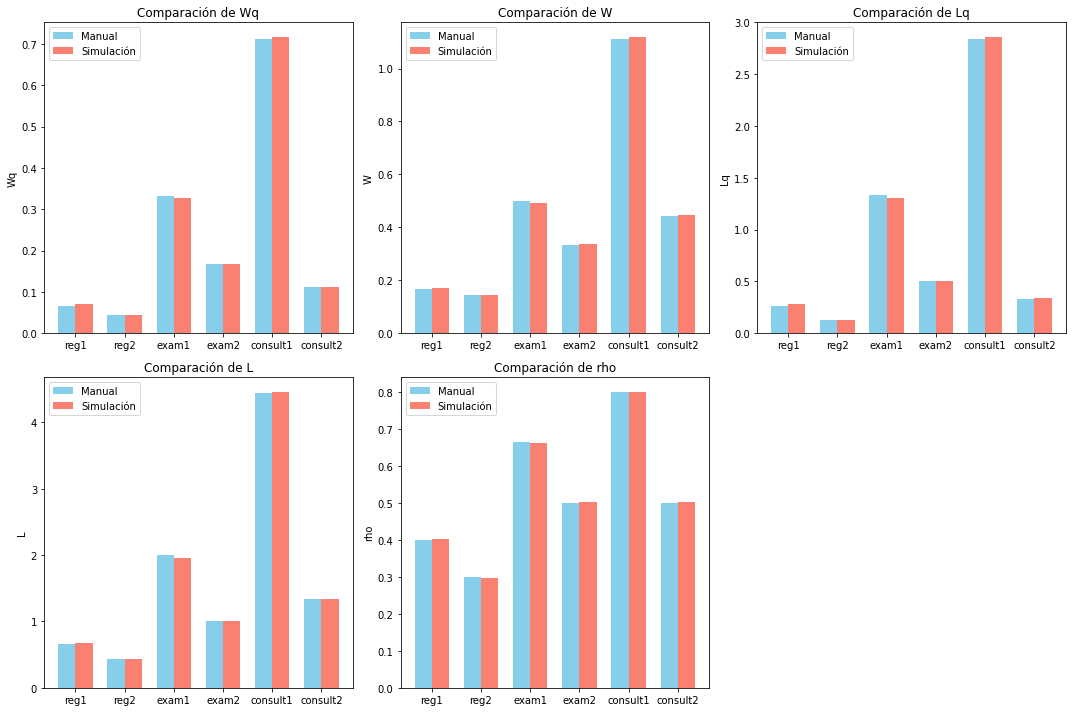

In [264]:
import matplotlib.pyplot as plt

# Crear DataFrame de métricas manuales
print("Métricas de desempeño calculadas manualmente:")
display(df_base_manual)

# Extraer de base_metrics las métricas simuladas para los mismos nodos
df_simulation = pd.DataFrame(base_metrics).T[['Wq', 'W', 'Lq', 'L', 'rho']]
print("\nMétricas de desempeño obtenidas en la simulación (Base):")
display(df_simulation)

# Crear un DataFrame con la diferencia (Simulación - Manual)
df_diff = (df_simulation - df_base_manual).round(5)
print("\nDiferencias (Simulación - Manual):")
display(df_diff)

# Graficar comparaciones para cada métrica
metric_names = ['Wq', 'W', 'Lq', 'L', 'rho']
nodes = df_base_manual.index.tolist()
x = range(len(nodes))
width = 0.35

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, metric in enumerate(metric_names):
    ax = axs[i]
    manual_vals = df_base_manual[metric]
    sim_vals = df_simulation[metric]
    ax.bar([p - width/2 for p in x], manual_vals, width=width, label='Manual', color='skyblue')
    ax.bar([p + width/2 for p in x], sim_vals, width=width, label='Simulación', color='salmon')
    ax.set_xticks(x)
    ax.set_xticklabels(nodes)
    ax.set_ylabel(metric)
    ax.set_title(f'Comparación de {metric}')
    ax.legend()

axs[-1].axis('off')

plt.tight_layout()
plt.show()

### Solución 4

Métricas de desempeño calculadas manualmente:


,Wq,W,Lq,L,rho
reg1,0.066667,0.166667,0.266667,0.666667,0.400000
reg2,0.042857,0.142857,0.128571,0.428571,0.300000
exam1,0.333333,0.500000,1.333333,2.000000,0.666667
exam2,0.166667,0.333333,0.500000,1.000000,0.500000
consult1,0.711111,1.111111,2.844444,4.444444,0.800000
consult2,0.111111,0.444444,0.333333,1.333333,0.500000



Métricas de desempeño obtenidas en la simulación (Base):


,Wq,W,Lq,L,rho
reg1,0.066627,0.166757,0.266637,0.667355,0.400718
reg2,0.042903,0.142762,0.128806,0.428607,0.299801
exam1,0.325427,0.492115,1.302345,1.969423,0.667079
exam2,0.171515,0.339565,0.514930,1.019454,0.504524
consult1,0.265379,0.665593,0.841580,2.110727,0.634573
consult2,0.240089,0.574346,0.920242,2.201352,0.640555



Diferencias (Simulación - Manual):


,Wq,W,Lq,L,rho
reg1,-0.00004,0.00009,-0.00003,0.00069,0.00072
reg2,0.00005,-0.00009,0.00023,0.00004,-0.00020
exam1,-0.00791,-0.00789,-0.03099,-0.03058,0.00041
exam2,0.00485,0.00623,0.01493,0.01945,0.00452
consult1,-0.44573,-0.44552,-2.00286,-2.33372,-0.16543
consult2,0.12898,0.12990,0.58691,0.86802,0.14056


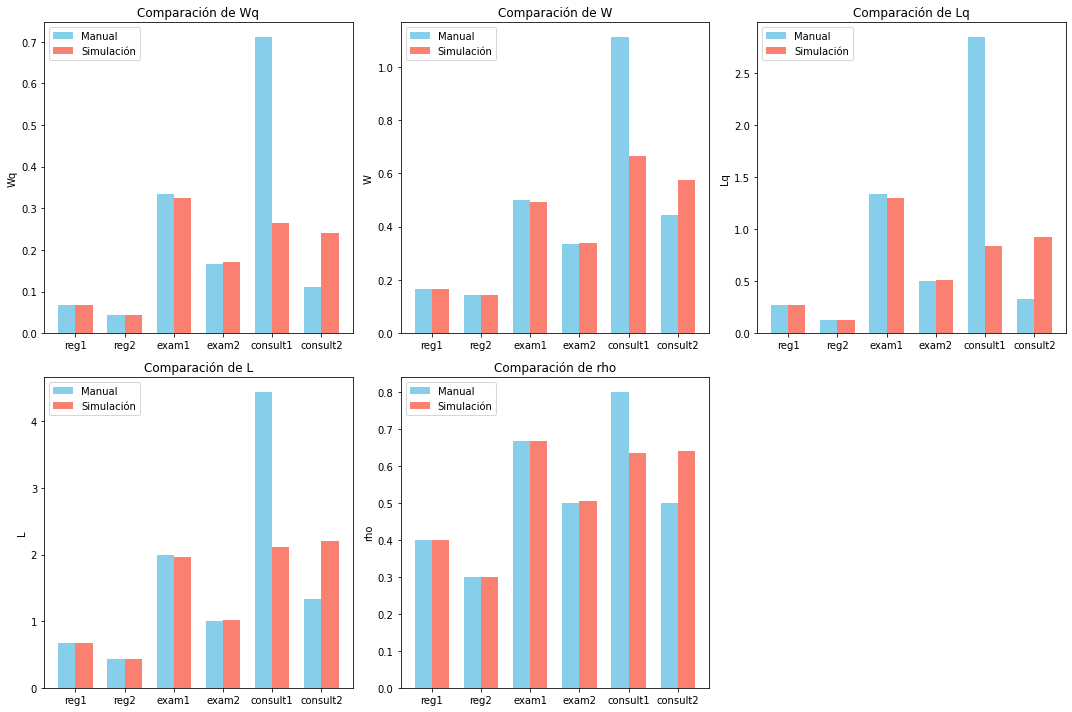

In [265]:
import matplotlib.pyplot as plt

# Crear DataFrame de métricas manuales
print("Métricas de desempeño calculadas manualmente:")
display(df_solution4_manual)

# Extraer de base_metrics las métricas simuladas para los mismos nodos
df_simulation = pd.DataFrame(solution4_metrics).T[['Wq', 'W', 'Lq', 'L', 'rho']]
print("\nMétricas de desempeño obtenidas en la simulación (Base):")
display(df_simulation)

# Crear un DataFrame con la diferencia (Simulación - Manual)
df_diff = (df_simulation - df_base_manual).round(5)
print("\nDiferencias (Simulación - Manual):")
display(df_diff)

# Graficar comparaciones para cada métrica
metric_names = ['Wq', 'W', 'Lq', 'L', 'rho']
nodes = df_base_manual.index.tolist()
x = range(len(nodes))
width = 0.35

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, metric in enumerate(metric_names):
    ax = axs[i]
    manual_vals = df_base_manual[metric]
    sim_vals = df_simulation[metric]
    ax.bar([p - width/2 for p in x], manual_vals, width=width, label='Manual', color='skyblue')
    ax.bar([p + width/2 for p in x], sim_vals, width=width, label='Simulación', color='salmon')
    ax.set_xticks(x)
    ax.set_xticklabels(nodes)
    ax.set_ylabel(metric)
    ax.set_title(f'Comparación de {metric}')
    ax.legend()

axs[-1].axis('off')

plt.tight_layout()
plt.show()